In [37]:
# changing core directory
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir('../../..')

In [38]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["KAGGLE_USERNAME"] = "recsysaccelerate"
os.environ["KAGGLE_KEY"] = "6363e91b656fea576c39e4f55dcc1d00"

In [39]:
from replay.preprocessing.filters import MinCountFilter, NumInteractionsFilter
from replay.splitters import TimeSplitter
from replay.data import (
    FeatureHint,
    FeatureInfo,
    FeatureSchema,
    FeatureSource,
    FeatureType,
    Dataset,
)
from replay.data.nn import (
    SequenceTokenizer,
    SequentialDataset,
    TensorFeatureSource,
    TensorSchema,
    TensorFeatureInfo
)

import pandas as pd

In [40]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42

np.random.seed(SEED)
random.seed(SEED)

## Prepare data

In [41]:
interactions = pd.read_parquet("/RePlay-Accelerated/replay_benchmarks/data/sports/interactions.parquet")

In [42]:
interactions

,user_id,item_id,rating,timestamp
0,AGGZ357AO26RQZVRLGU4D4N52DZQ,B00GAG0LDO,4.0,1438304920000
1,AGGZ357AO26RQZVRLGU4D4N52DZQ,B07NJ2SZQX,5.0,1573237536081
2,AGGZ357AO26RQZVRLGU4D4N52DZQ,B01DFBQEKA,5.0,1612126664309
3,AGGZ357AO26RQZVRLGU4D4N52DZQ,B09NQK7MH9,5.0,1612965746894
4,AGGZ357AO26RQZVRLGU4D4N52DZQ,B00IET8S80,5.0,1627330911189
...,...,...,...,...
3472015,AFHRVIU2OJZO7P2QKZ6RM26IGU7Q,B00CHSCJ7A,5.0,1464109994000
3472016,AFHRVIU2OJZO7P2QKZ6RM26IGU7Q,B00IJJ3YRK,5.0,1478598475000
3472017,AFHRVIU2OJZO7P2QKZ6RM26IGU7Q,B002BIPGQM,5.0,1478598884000
3472018,AFHRVIU2OJZO7P2QKZ6RM26IGU7Q,B0000B0FYY,5.0,1482877835000


In [43]:
interactions['rating'].describe()

count    2.947464e+06
mean     4.818351e+00
std      3.855548e-01
min      4.000000e+00
25%      5.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [44]:
print(f"Number of unique users: {interactions.user_id.nunique()}")
print(f"Number of unique items: {interactions.item_id.nunique()}")

Number of unique users: 408583
Number of unique items: 156157


In [45]:
pd.to_datetime(interactions['timestamp'], unit='ms').describe()

count                          2947464
mean     2018-07-14 16:51:55.276171776
min                2002-03-07 18:25:30
25%      2016-05-04 22:54:33.249999872
50%      2018-08-02 15:07:17.488999936
75%      2020-11-09 11:22:53.529250048
max         2023-09-11 14:59:53.843000
Name: timestamp, dtype: object

In [46]:
pd.to_datetime(interactions['timestamp'], unit='ms')

0         2015-07-31 01:08:40.000
1         2019-11-08 18:25:36.081
2         2021-01-31 20:57:44.309
3         2021-02-10 14:02:26.894
4         2021-07-26 20:21:51.189
                    ...          
3472015   2016-05-24 17:13:14.000
3472016   2016-11-08 09:47:55.000
3472017   2016-11-08 09:54:44.000
3472018   2016-12-27 22:30:35.000
3472019   2016-12-27 22:34:26.000
Name: timestamp, Length: 2947464, dtype: datetime64[ns]

In [47]:
interactions.head()

,user_id,item_id,rating,timestamp
0,AGGZ357AO26RQZVRLGU4D4N52DZQ,B00GAG0LDO,4.0,1438304920000
1,AGGZ357AO26RQZVRLGU4D4N52DZQ,B07NJ2SZQX,5.0,1573237536081
2,AGGZ357AO26RQZVRLGU4D4N52DZQ,B01DFBQEKA,5.0,1612126664309
3,AGGZ357AO26RQZVRLGU4D4N52DZQ,B09NQK7MH9,5.0,1612965746894
4,AGGZ357AO26RQZVRLGU4D4N52DZQ,B00IET8S80,5.0,1627330911189


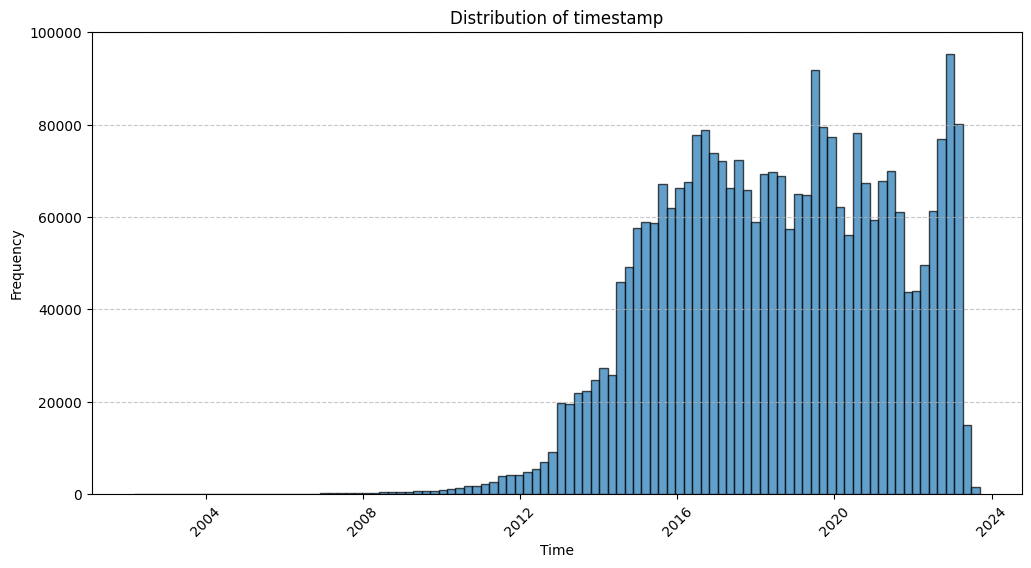

In [48]:
def plot_timestamp_distribution(df: pd.DataFrame, timestamp_col: str = 'timestamp', unit: str = 'ms', bins: int = 100):
    df = df.copy()
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], unit=unit)
    df = df.sort_values(timestamp_col)
    
    plt.figure(figsize=(12, 6))
    plt.hist(df[timestamp_col], bins=bins, edgecolor='black', alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {timestamp_col}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_timestamp_distribution(interactions)


In [49]:
# Фильтруем данные по минимальному рейтингу
interactions = interactions[
                interactions['rating']
                > 3
            ]

In [50]:
def filter_data(interactions: pd.DataFrame):
    """Filters raw data based on minimum interaction counts."""

    def log_min_counts(data: pd.DataFrame, message_prefix: str):
        user_min = data.groupby("user_id").size().min()
        item_min = data.groupby("item_id").size().min()
        print(
            f"{message_prefix} - Min items per user: {user_min}, Min users per item: {item_min}"
        )

    log_min_counts(interactions, "Before filtering")

    interactions = MinCountFilter(
        num_entries=5,
        groupby_column="item_id",
    ).transform(interactions)

    interactions = MinCountFilter(
        num_entries=3,
        groupby_column="user_id",
    ).transform(interactions)

    log_min_counts(interactions, "After filtering")

    return interactions

interactions = filter_data(interactions)

Before filtering - Min items per user: 1, Min users per item: 1
After filtering - Min items per user: 3, Min users per item: 2


In [74]:
print(interactions.shape)
print(pd.to_datetime(interactions.timestamp.min(), unit='ms'))
print(pd.to_datetime(interactions.timestamp.max(), unit='ms'))
density = (len(interactions) / (interactions['user_id'].nunique() * interactions['item_id'].nunique())) * 100
print(f"Interaction Density: {density:.2f}%")
mean_seq_len = interactions.groupby('user_id').size().mean()
print(f"Mean Sequence Length: {mean_seq_len:.2f}")

(2843145, 4)
2002-03-07 18:25:30
2023-09-11 14:59:53.843000
Interaction Density: 0.01%
Mean Sequence Length: 7.28


In [52]:
print(f"Number of unique users: {interactions.user_id.nunique()}")
print(f"Number of unique items: {interactions.item_id.nunique()}")

Number of unique users: 390505
Number of unique items: 135111


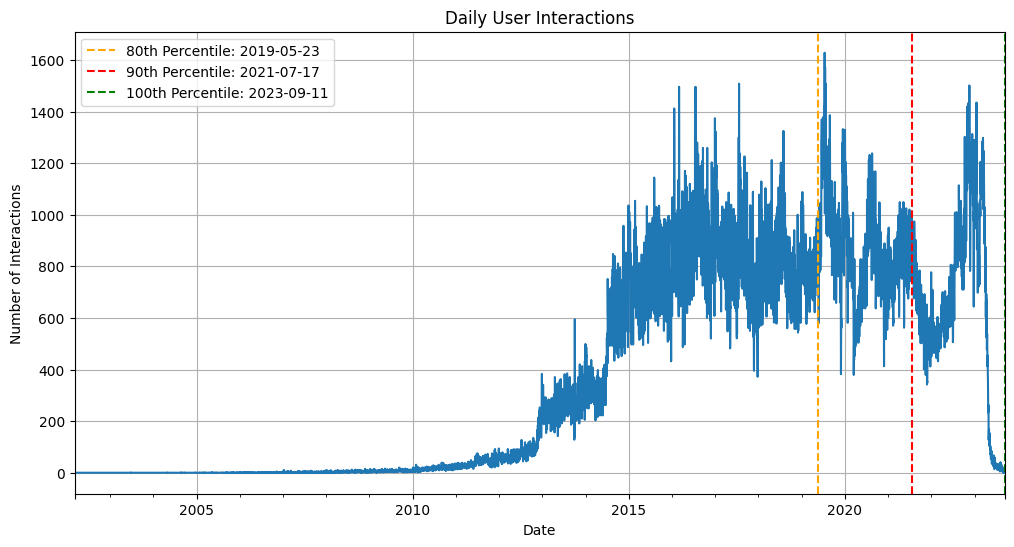

In [53]:
temp_interactions = interactions.copy()
temp_interactions['timestamp'] = pd.to_datetime(temp_interactions['timestamp'], unit='ms')
daily_interactions = temp_interactions.resample('D', on='timestamp').size()
percentile_80_date = daily_interactions.index[int(0.8 * len(daily_interactions)) - 1]
percentile_90_date = daily_interactions.index[int(0.9 * len(daily_interactions)) - 1]
percentile_100_date = daily_interactions.index[int(1 * len(daily_interactions)) - 1]
plt.figure(figsize=(12, 6))
daily_interactions.plot()
plt.title('Daily User Interactions')
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.axvline(x=percentile_80_date, color='orange', linestyle='--', label=f'80th Percentile: {percentile_80_date.date()}')
plt.axvline(x=percentile_90_date, color='red', linestyle='--', label=f'90th Percentile: {percentile_90_date.date()}')
plt.axvline(x=percentile_100_date, color='green', linestyle='--', label=f'100th Percentile: {percentile_100_date.date()}')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
def split_data(interactions):
    """Split data for training, validation, and testing."""
    splitter = TimeSplitter(
        time_threshold=0.1,
        drop_cold_users=True,
        drop_cold_items=True,
        item_column="item_id",
        query_column="user_id",
        timestamp_column="timestamp",
    )

    test_events, test_gt = splitter.split(interactions)
    validation_events, validation_gt = splitter.split(test_events)
    train_events = validation_events

    test_gt = test_gt[
        test_gt["item_id"].isin(train_events["item_id"])
    ]
    test_gt = test_gt[
        test_gt["user_id"].isin(train_events["user_id"])
    ]

    print(
        f"Distribution of seq_len in validation:\n{validation_gt.groupby('user_id')['item_id'].agg('count').describe()}."
    )
    print(
        f"Distribution of seq_len in test:\n{test_gt.groupby('user_id')['item_id'].agg('count').describe()}."
    )
    max_test_interactions = 200

    if max_test_interactions is not None:

        validation_gt = NumInteractionsFilter(
            num_interactions=max_test_interactions,
            first=True,
            query_column='user_id',
            item_column='item_id',
            timestamp_column='timestamp',
        ).transform(validation_gt)
        print(
            f"Distribution of seq_len in validation  after filtering:\n{validation_gt.groupby('user_id')['item_id'].agg('count').describe()}."
        )

        test_gt = NumInteractionsFilter(
            num_interactions=max_test_interactions,
            first=True,
            query_column='user_id',
            item_column='item_id',
            timestamp_column='timestamp',
        ).transform(test_gt)
        print(
            f"Distribution of seq_len in test after filtering:\n{test_gt.groupby('user_id')['item_id'].agg('count').describe()}."
        )
    else:
        print("max_num_test_interactions is null. Skipping filtration.")

    return {
        "train": train_events,
        "validation": validation_events,
        "validation_gt": validation_gt,
        "test": test_events,
        "test_gt": test_gt,
    }

splits = split_data(interactions)

Distribution of seq_len in validation:
count    96240.000000
mean         1.902670
std          1.665135
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         44.000000
Name: item_id, dtype: float64.
Distribution of seq_len in test:
count    53490.000000
mean         1.684726
std          1.439600
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         45.000000
Name: item_id, dtype: float64.
Distribution of seq_len in validation  after filtering:
count    96240.000000
mean         1.902670
std          1.665135
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         44.000000
Name: item_id, dtype: float64.
Distribution of seq_len in test after filtering:
count    53490.000000
mean         1.684726
std          1.439600
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         45.000000
Name: item_id, dtype: floa

In [55]:
def prepare_feature_schema(is_ground_truth: bool) -> FeatureSchema:
    """Prepare the feature schema based on whether ground truth is needed."""
    base_features = FeatureSchema(
        [
            FeatureInfo(
                column="user_id",
                feature_hint=FeatureHint.QUERY_ID,
                feature_type=FeatureType.CATEGORICAL,
            ),
            FeatureInfo(
                column="item_id",
                feature_hint=FeatureHint.ITEM_ID,
                feature_type=FeatureType.CATEGORICAL,
            ),
        ]
    )
    if is_ground_truth:
        return base_features

    return base_features + FeatureSchema(
        [
            FeatureInfo(
                column="timestamp",
                feature_type=FeatureType.NUMERICAL,
                feature_hint=FeatureHint.TIMESTAMP,
            ),
        ]
    )

def prepare_datasets(
        train_events,
        validation_events,
        validation_gt,
        test_events,
        test_gt,
    ):
    """Prepare Dataset objects for training, validation, and testing."""
    train_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=train_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    validation_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=validation_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    validation_gt_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=True),
        interactions=validation_gt,
        check_consistency=True,
        categorical_encoded=False,
    )
    test_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=test_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    test_gt_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=True),
        interactions=test_gt,
        check_consistency=True,
        categorical_encoded=False,
    )

    return (
        train_dataset,
        validation_dataset,
        validation_gt_dataset,
        test_dataset,
        test_gt_dataset,
    )

train_dataset, val_dataset, val_gt_dataset, test_dataset, test_gt_dataset = (
    prepare_datasets(*splits.values())
)
item_count = train_dataset.item_count

In [56]:
tensor_schema = TensorSchema(
    TensorFeatureInfo(
        name="item_id_seq",
        is_seq=True,
        feature_type=FeatureType.CATEGORICAL,
        feature_sources=[
            TensorFeatureSource(
                FeatureSource.INTERACTIONS,
                "item_id",
            )
        ],
        feature_hint=FeatureHint.ITEM_ID,
        embedding_dim=128,
    )
)

def initialize_tokenizer(train_dataset: Dataset, tensor_schema) -> SequenceTokenizer:
    """Initialize and fit the SequenceTokenizer."""
    tokenizer = SequenceTokenizer(
        tensor_schema, allow_collect_to_master=True, handle_unknown_rule="drop"
    )
    tokenizer.fit(train_dataset)
    return tokenizer

def prepare_sequential_validation(
        validation_dataset: Dataset, validation_gt: Dataset, tokenizer
    ):
    """Prepare sequential datasets for validation."""
    seq_validation_dataset = tokenizer.transform(validation_dataset)
    seq_validation_gt = tokenizer.transform(
        validation_gt, [tensor_schema.item_id_feature_name]
    )

    return SequentialDataset.keep_common_query_ids(
        seq_validation_dataset, seq_validation_gt
    )

def prepare_sequential_test(
    test_dataset: Dataset, test_gt: Dataset, tokenizer
) -> SequentialDataset:
    """Prepare sequential dataset for testing."""
    test_query_ids = test_gt.query_ids
    test_query_ids_np = tokenizer.query_id_encoder.transform(test_query_ids)[
        "user_id"
    ].values
    return tokenizer.transform(test_dataset).filter_by_query_id(
        test_query_ids_np
    )
    
def prepare_seq_datasets(
    train_dataset: Dataset,
    validation_dataset: Dataset,
    validation_gt: Dataset,
    test_dataset: Dataset,
    test_gt: Dataset,
):
    """Prepare SequentialDataset objects for training, validation, and testing."""
    tokenizer = initialize_tokenizer(train_dataset, tensor_schema)

    seq_train_dataset = tokenizer.transform(train_dataset)
    seq_validation_dataset, seq_validation_gt = prepare_sequential_validation(
        validation_dataset, validation_gt, tokenizer
    )
    seq_test_dataset = prepare_sequential_test(test_dataset, test_gt, tokenizer)

    return (
        seq_train_dataset,
        seq_validation_dataset,
        seq_validation_gt,
        seq_test_dataset,
    )

(
    seq_train_dataset,
    seq_validation_dataset,
    seq_validation_gt,
    seq_test_dataset,
    ) = prepare_seq_datasets(train_dataset, val_dataset, val_gt_dataset, test_dataset, test_gt_dataset)

In [57]:
# Valid_dataset 
exploded_df = seq_validation_dataset._sequences.explode(seq_validation_dataset._item_id_column)
unique_item_ids = exploded_df[seq_validation_dataset._item_id_column].unique()
unique_query_ids = seq_validation_dataset._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_validation_dataset._sequences[seq_validation_dataset._item_id_column].apply(len)
sequence_lengths.describe()

Number of unique item_ids: 102427
Number of unique query_ids: 96240


count    96240.000000
mean         5.744701
std          7.127527
min          1.000000
25%          3.000000
50%          4.000000
75%          6.000000
max        461.000000
Name: item_id_seq, dtype: float64

In [58]:
# Valid_gt 
exploded_df = seq_validation_gt._sequences.explode(seq_validation_gt._item_id_column)
unique_item_ids = exploded_df[seq_validation_gt._item_id_column].unique()
unique_query_ids = seq_validation_gt._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_validation_gt._sequences[seq_validation_gt._item_id_column].apply(len)
print(sequence_lengths.describe())
print(splits['validation_gt'].shape)

Number of unique item_ids: 46122
Number of unique query_ids: 96240
count    96240.000000
mean         1.902670
std          1.665135
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         44.000000
Name: item_id_seq, dtype: float64
(183113, 4)


In [59]:
# Test_dataset 
exploded_df = seq_test_dataset._sequences.explode(seq_test_dataset._item_id_column)
unique_item_ids = exploded_df[seq_test_dataset._item_id_column].unique()
unique_query_ids = seq_test_dataset._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_test_dataset._sequences[seq_test_dataset._item_id_column].apply(len)
sequence_lengths.describe()

Number of unique item_ids: 89075
Number of unique query_ids: 53490


count    53490.000000
mean         6.615910
std          8.262591
min          1.000000
25%          3.000000
50%          4.000000
75%          7.000000
max        477.000000
Name: item_id_seq, dtype: float64

In [60]:
# Test_gt
print(f"Number of unique item_ids: {splits['test_gt'].item_id.nunique()}")
print(f"Number of unique query_ids: {splits['test_gt'].user_id.nunique()}")
print(splits['test_gt'].groupby('user_id')['item_id'].agg('count').describe())
print(splits['test_gt'].shape)

Number of unique item_ids: 31218
Number of unique query_ids: 53490
count    53490.000000
mean         1.684726
std          1.439600
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         45.000000
Name: item_id, dtype: float64
(90116, 4)


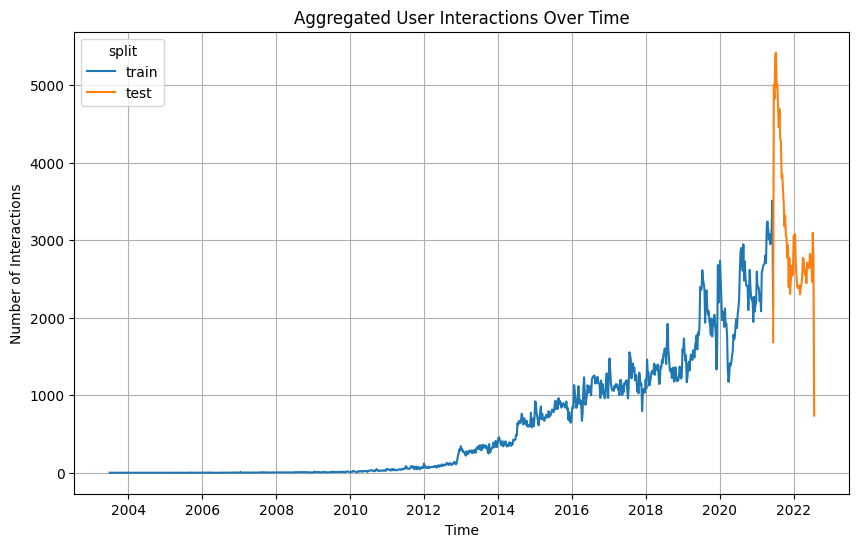

In [61]:
def plot_aggregated_interactions(train, test, time_unit='W'):
    train = train.copy()
    test = test.copy()
    train['timestamp'] = pd.to_datetime(train['timestamp'], unit='ms')
    test['timestamp'] = pd.to_datetime(test['timestamp'], unit='ms')

    train_agg = train.resample(time_unit, on='timestamp').size().reset_index(name='count')
    test_agg = test.resample(time_unit, on='timestamp').size().reset_index(name='count')

    train_agg['split'] = 'train'
    test_agg['split'] = 'test'

    combined_agg = pd.concat([train_agg, test_agg])

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=combined_agg, x='timestamp', y='count', hue='split')
    plt.title('Aggregated User Interactions Over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Interactions')
    plt.grid(True)
    plt.show()

val = splits['validation'][splits['validation'].user_id.isin(splits['validation_gt'].user_id.unique())]
val_gt = splits['validation_gt']
plot_aggregated_interactions(val, val_gt)

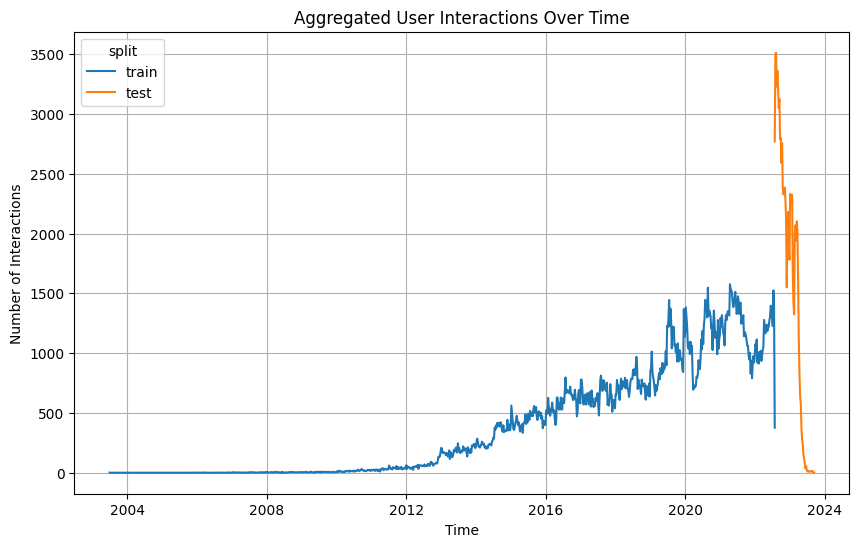

In [62]:
test = splits['test'][splits['test'].user_id.isin(splits['test_gt'].user_id.unique())]
test_gt = splits['test_gt']
plot_aggregated_interactions(test, test_gt)

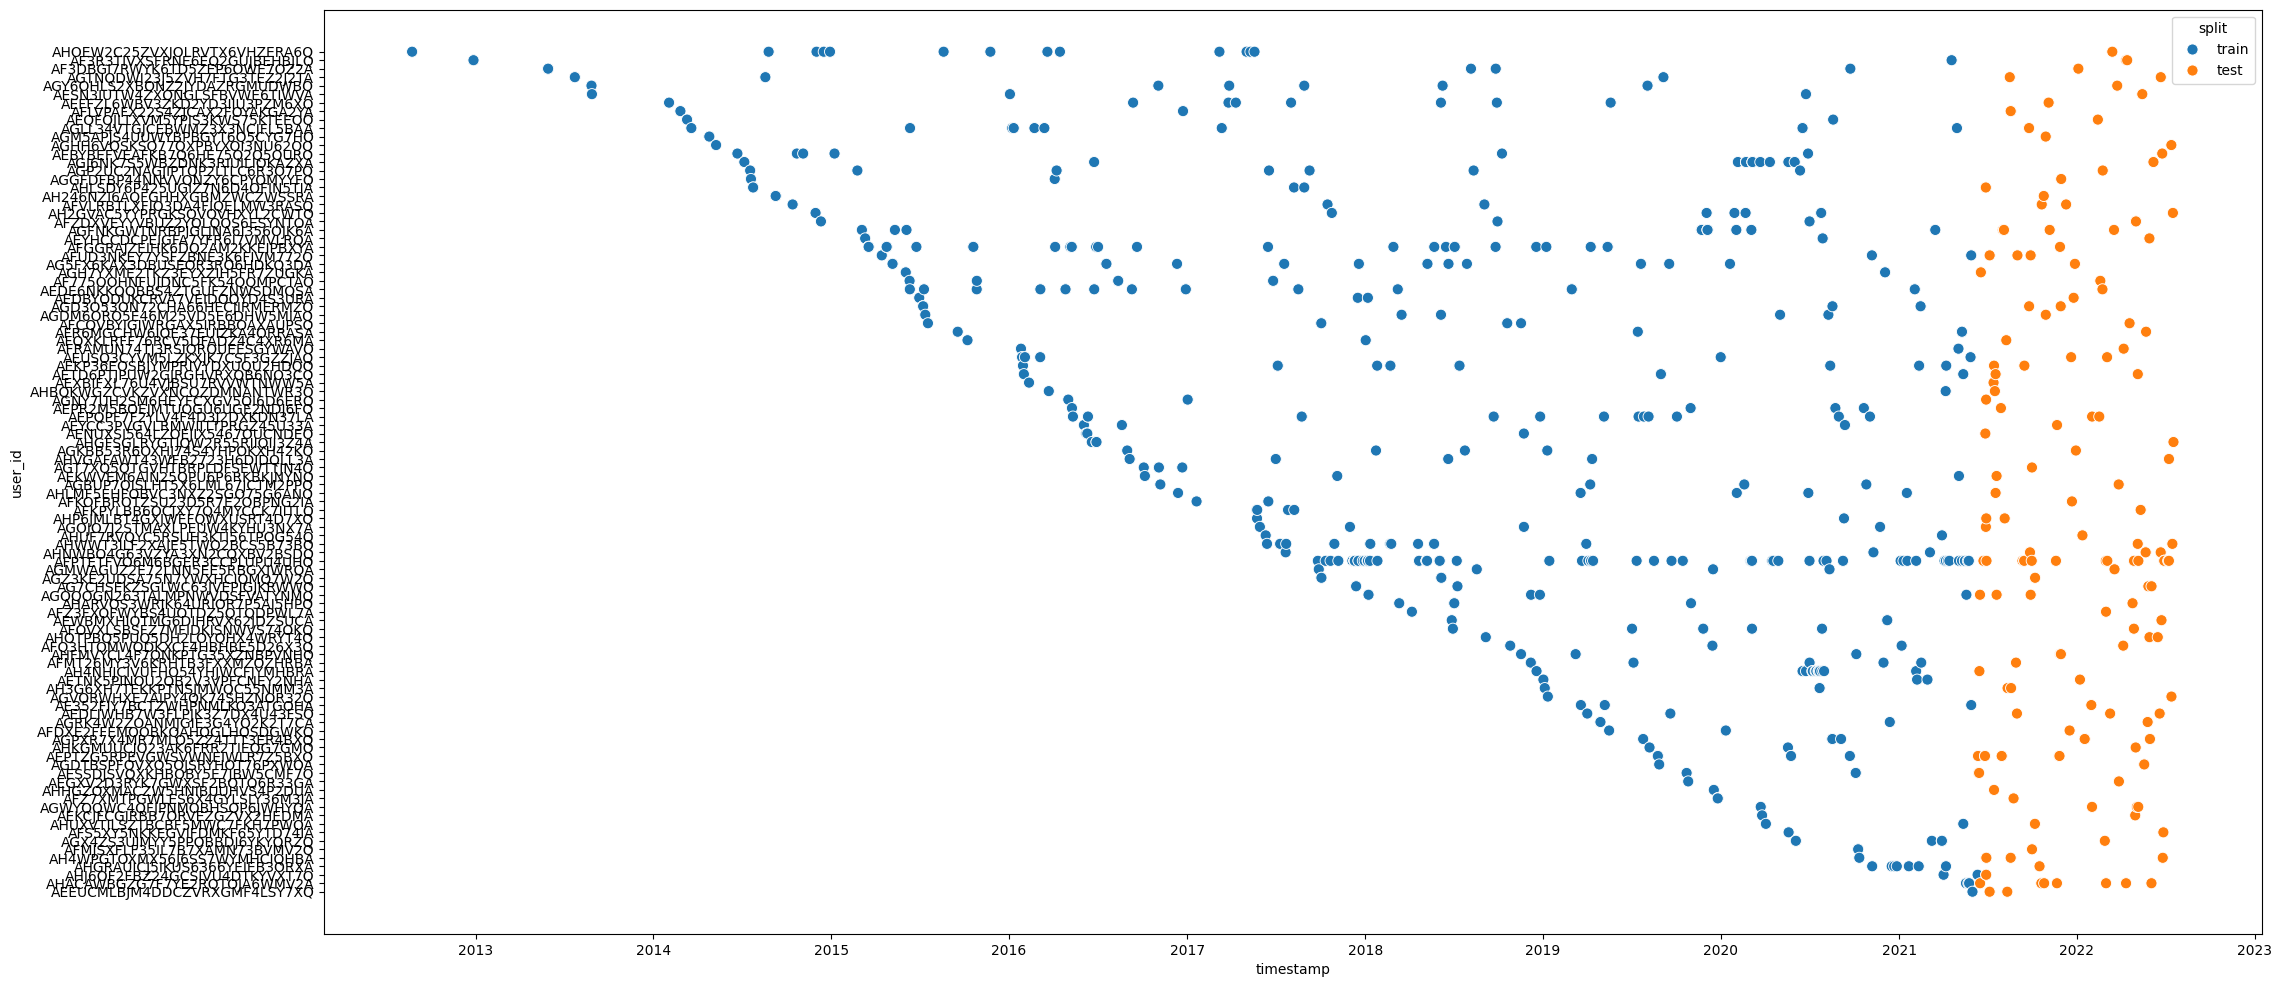

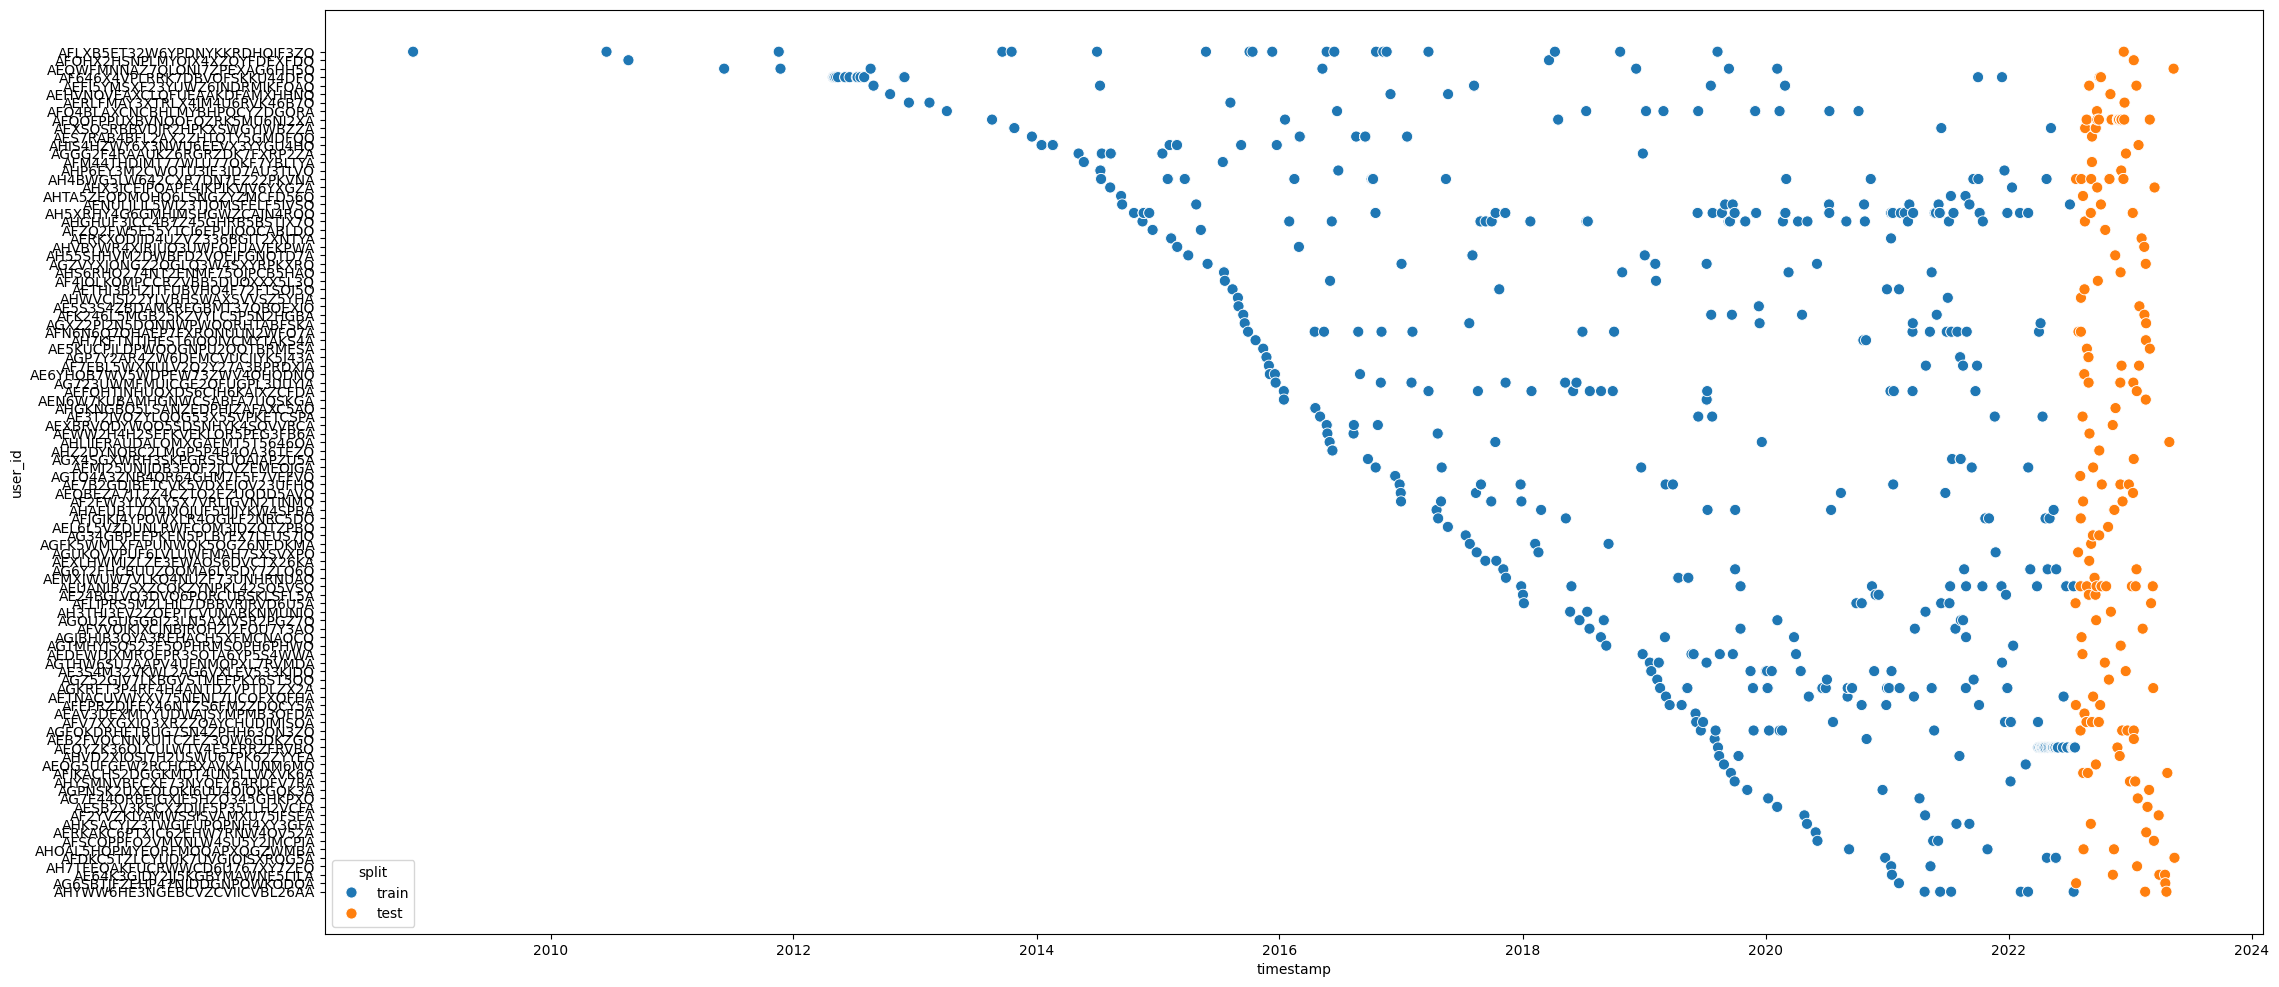

In [63]:
def show_train_test_sampled(train, test, sample_size=100):
    train = train.copy()
    test = test.copy()
    train['timestamp'] = pd.to_datetime(train['timestamp'], unit='ms')
    test['timestamp'] = pd.to_datetime(test['timestamp'], unit='ms')
    train['split'] = 'train'
    test['split'] = 'test'
    combined = pd.concat([train, test])
    sampled_user_ids = np.random.choice(combined['user_id'].unique(), size=sample_size, replace=False)

    sampled_data = combined[combined['user_id'].isin(sampled_user_ids)]
    plt.figure(figsize=(25, 12))
    sns.scatterplot(data=sampled_data, x='timestamp', y='user_id', hue='split', s=64)
    plt.autoscale(enable=True, axis='x')
    plt.grid(False)
    plt.show()


show_train_test_sampled(val, val_gt)
show_train_test_sampled(test, test_gt)

In [64]:
splits['train'][splits['train'].user_id.isin(test_gt.user_id)]

,user_id,item_id,rating,timestamp
9199,AGWDYYVVWM3DC3CASUZKXK67G6IA,B00005JD3W,5.0,1056761361000
1123620,AG4IUZOBRU3744ZORUNJVMSZZGTQ,B0007IS62E,5.0,1125440565000
2532728,AG7MIFEQUX2O4U4CTPAVMO75PGEQ,B0007IS6ZG,4.0,1131574643000
441351,AGN4UPRC47V46LR2AGIKLOAYQ2DA,B0007W2F6I,5.0,1131751039000
931236,AEH4VS4ELLJE4WZIIEKFJWAEWMHA,B07DCF1M2Q,5.0,1133968037000
...,...,...,...,...
2372737,AFR74EZUOEXD5UWR7ANRJAS3DPSA,B07TW4WMG5,5.0,1623405972468
651199,AFAE6QOPYBEDEBW36A74X35ESDXA,B08CC2XXLY,5.0,1623407427667
3309513,AGULH644QJBIVXBAWINJKTCBVIAA,B075NMXF3R,5.0,1623408866378
416261,AEJNWQ2NUHYHRLQUITQFLKEZYZ6Q,B07C3CQSFL,5.0,1623409475081


In [65]:
len(set(splits['train'].item_id))

118738

In [66]:
len(set(val_gt.item_id))

46122

In [67]:
len(set(test_gt.item_id)) 

31218

In [68]:
len(set(test_gt.item_id) - set(val_gt.item_id))

6411

In [69]:
splits['train'][splits['train'].item_id.isin(set(test_gt.item_id) - set(val_gt.item_id))]

,user_id,item_id,rating,timestamp
931236,AEH4VS4ELLJE4WZIIEKFJWAEWMHA,B07DCF1M2Q,5.0,1133968037000
1895234,AF5AHTETTRZ5MK4Z5XCIS5IU5ZWQ,B0000YQVFE,5.0,1135520645000
325194,AHUNA77FTMT6XDXKVMCZVOPNGJKQ,B07MHRHXLW,5.0,1136678827000
1760820,AEQZRXHHZCLBNGLYEFE2RK26TDRQ,B000MTRX9U,5.0,1142614235000
1281956,AE23E3DVGHTK3VDGUNE2MKN2DABQ,B0000YQVFE,5.0,1142788660000
...,...,...,...,...
604940,AFJ47WB4QNDK4RJQ2GUZ3NPGRVIA,B09Q89XVRC,5.0,1623390071310
311959,AGMO25NSI27D64W37GCW2T7W3R4A,B077M4T1SY,5.0,1623397164163
615180,AH3GBNBFJ6PKAJXHT5PBD2TGDU5Q,B082241HJJ,5.0,1623401238037
969760,AEFHEEB37W6E6NCTT5GWEXATVUEA,B07BHWNKBL,5.0,1623408951045


In [70]:
len(set(val_gt.item_id) - set(test_gt.item_id))

21315

In [71]:
splits['train'][splits['train'].item_id.isin(set(val_gt.item_id) - set(test_gt.item_id))]

,user_id,item_id,rating,timestamp
3356323,AGA23SFJHFLORYVRY7SZVMLNMZVQ,B07PZHV14C,4.0,1083297554000
357352,AEBJVBOBUSND7RHN3J5WEDPHIFWA,B07PPVRY57,5.0,1093039684000
1673494,AG4BIBGAISKUWUQ6ZEBFLIHQKGXA,B07PZHV14C,4.0,1093967547000
1666405,AFJBF2GCMSFDATUPSSGT3VDHTOKA,B07C6217FL,4.0,1110202337000
3114128,AGXQXXHH7MMFU6NNXFDMOLD5ZCYQ,B097FTLVSJ,5.0,1126647210000
...,...,...,...,...
3091174,AHY25TIMP4QEG422LTEHTUEUZXRQ,B07PB33DKB,5.0,1623406840264
3309513,AGULH644QJBIVXBAWINJKTCBVIAA,B075NMXF3R,5.0,1623408866378
1888445,AHHYZGP5MRG2TRZOXS2REIZZWFXQ,B0746WKVNN,5.0,1623408934957
845653,AFN4IKDXVWN6LI37ZUCDYTQ5HV6Q,B07GH1YK9Z,5.0,1623409028648


In [72]:
test_gt

,user_id,item_id,rating,timestamp
2973283,AHFHKMKJK2XGM2BMU32G4WVGZNFA,B00C2LWOMM,5.0,1658225346849
2910439,AGJGFFJ7DUBO3EOH2SNTMLQTQZJQ,B082MTDNRH,5.0,1658226635799
1882212,AGJEY54T4FVKB3ASGHYI3W4CH36Q,B0746Z62P8,5.0,1658226803824
1672106,AFPKA5NUEMME64KTQESU7OVX4X2Q,B07PG81FPJ,5.0,1658226876652
1672107,AFPKA5NUEMME64KTQESU7OVX4X2Q,B0BXQ4BH3T,5.0,1658226986420
...,...,...,...,...
3456894,AFQS5O3LBKKHCPBQXOJJFCW3VPMQ,B08KLDN46C,4.0,1692989627044
3469910,AG2D6HWPZPFKO4ZOKZA45IWU6QOA,B0778D9365,5.0,1693177952912
3462092,AERNY7QO7SLFP3XY6AOFYUW54WAA,B0C113L4HS,5.0,1693189183838
3461861,AF4YFD5LZ5JQ5RHSN2CBMA2ZGLBQ,B08L1BV8RB,5.0,1693276407370


In [73]:
test_gt[test_gt.item_id.isin(val_gt.item_id.unique())]

,user_id,item_id,rating,timestamp
2973283,AHFHKMKJK2XGM2BMU32G4WVGZNFA,B00C2LWOMM,5.0,1658225346849
2910439,AGJGFFJ7DUBO3EOH2SNTMLQTQZJQ,B082MTDNRH,5.0,1658226635799
1882212,AGJEY54T4FVKB3ASGHYI3W4CH36Q,B0746Z62P8,5.0,1658226803824
1672106,AFPKA5NUEMME64KTQESU7OVX4X2Q,B07PG81FPJ,5.0,1658226876652
1672107,AFPKA5NUEMME64KTQESU7OVX4X2Q,B0BXQ4BH3T,5.0,1658226986420
...,...,...,...,...
3456894,AFQS5O3LBKKHCPBQXOJJFCW3VPMQ,B08KLDN46C,4.0,1692989627044
3469910,AG2D6HWPZPFKO4ZOKZA45IWU6QOA,B0778D9365,5.0,1693177952912
3462092,AERNY7QO7SLFP3XY6AOFYUW54WAA,B0C113L4HS,5.0,1693189183838
3461861,AF4YFD5LZ5JQ5RHSN2CBMA2ZGLBQ,B08L1BV8RB,5.0,1693276407370
